### Group 5 - Gurusankar Gopalakrishnan, Unsupervised Clustering of Sentiment Scores from 10K Financial Reports

In [0]:
import os
import pandas as pd
import numpy as np
import pyspark
import datetime
from pyspark.sql import Row, SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql.window import Window
import warnings
import json
import gc
warnings.filterwarnings('ignore')

In [0]:
spark = SparkSession.builder.getOrCreate()

In [0]:
# REF_STRING = "mongodb+srv://admin:<password>@msds697-cluster.qzgwq.mongodb.net/"
def read_df_from_mongo(spark, collection_name):
    mongo_username = 'admin'
    mongo_password =  'msds697'
    mongo_ip_address = 'msds697-cluster.qzgwq.mongodb.net/'
    MONGO_DB_NAME = "msds697_project"
    connection_string = f"mongodb+srv://{mongo_username}:{mongo_password}@{mongo_ip_address}{MONGO_DB_NAME}.{collection_name}"
    spark_df = spark.read.format("mongo").option("uri", connection_string).load()
    return spark_df
    
def store_df_to_mongo(spark, spark_df, collection_name):
    mongo_username = 'admin'
    mongo_password =  'msds697'
    mongo_ip_address = 'msds697-cluster.qzgwq.mongodb.net/'
    MONGO_DB_NAME = "msds697_project"
    connection_string = f"mongodb+srv://{mongo_username}:{mongo_password}@{mongo_ip_address}{MONGO_DB_NAME}.{collection_name}"
    spark_df.write.format("com.mongodb.spark.sql.DefaultSource")\
                     .mode("append")\
                     .option("uri", connection_string)\
                     .save()

#### Fetch raw sentiment score vectors data from Mongo Atlas

In [0]:
sentiment_df = read_df_from_mongo(spark, "sentiment_raw_financial_vectors_2")
sentiment_df.printSchema()

root
-- _id: struct (nullable = true)
 |-- oid: string (nullable = true)
-- cik: string (nullable = true)
-- company: string (nullable = true)
-- complete_text_filing_link: string (nullable = true)
-- filename: string (nullable = true)
-- filing_date: string (nullable = true)
-- filing_html_index: string (nullable = true)
-- filing_type: string (nullable = true)
-- fiscal_year_end: string (nullable = true)
-- htm_filing_link: string (nullable = true)
-- length: integer (nullable = true)
-- period_of_report: string (nullable = true)
-- sic: string (nullable = true)
-- state_location: string (nullable = true)
-- state_of_inc: string (nullable = true)
-- vectors: array (nullable = true)
 |-- element: array (containsNull = true)
 | |-- element: double (containsNull = true)

#### Data Pre-Processing

In [0]:
senti_feats_df = sentiment_df.select('company','vectors','state_of_inc','state_location')
senti_feats_df.printSchema()

root
-- company: string (nullable = true)
-- vectors: array (nullable = true)
 |-- element: array (containsNull = true)
 | |-- element: double (containsNull = true)
-- state_of_inc: string (nullable = true)
-- state_location: string (nullable = true)

In [0]:
senti_flat_scores = senti_feats_df.rdd.map(lambda x: x["vectors"]).map(lambda x: np.array(x))\
.map(lambda x: x[x[:,2]<0.5].sum(axis = 0))\
.map(lambda x: x/x.sum())

senti_flat_scores.count()

senti_feats_df.take(5)

Out[7]: [Row(company='Pacira BioSciences, Inc.', vectors=[[0.08782958984375, 0.1942138671875, 0.7177734375], [0.029998779296875, 0.04119873046875, 0.9287109375], [0.0239410400390625, 0.0670166015625, 0.9091796875], [0.10321044921875, 0.08929443359375, 0.8076171875], [0.263671875, 0.007717132568359375, 0.728515625], [0.62841796875, 0.0081787109375, 0.363525390625], [0.115234375, 0.09747314453125, 0.787109375], [0.3662109375, 0.007587432861328125, 0.6259765625], [0.075927734375, 0.07562255859375, 0.8486328125], [0.1339111328125, 0.31640625, 0.5498046875], [0.11865234375, 0.166748046875, 0.71484375], [0.0830078125, 0.014434814453125, 0.90234375], [0.11785888671875, 0.1007080078125, 0.78125], [0.037994384765625, 0.051055908203125, 0.9111328125], [0.0310821533203125, 0.0217437744140625, 0.947265625], [0.13037109375, 0.169921875, 0.69970703125], [0.03228759765625, 0.70703125, 0.260498046875], [0.03265380859375, 0.050140380859375, 0.9169921875], [0.1314697265625, 0.314208984375, 0.55419921875], [0.10784912109375, 0.10235595703125, 0.78955078125], [0.1282958984375, 0.1905517578125, 0.68115234375], [0.1163330078125, 0.1009521484375, 0.78271484375], [0.06494140625, 0.01776123046875, 0.91748046875], [0.06781005859375, 0.09906005859375, 0.8330078125], [0.08837890625, 0.169921875, 0.74169921875], [0.833984375, 0.008575439453125, 0.1573486328125], [0.01506805419921875, 0.9296875, 0.0552978515625], [0.043731689453125, 0.04022216796875, 0.916015625], [0.46630859375, 0.031341552734375, 0.50244140625], [0.06268310546875, 0.04644775390625, 0.89111328125], [0.036590576171875, 0.63232421875, 0.331298828125], [0.1331787109375, 0.31640625, 0.55029296875], [0.11865234375, 0.166748046875, 0.71484375], [0.122314453125, 0.10498046875, 0.7724609375], [0.042877197265625, 0.1798095703125, 0.77734375], [0.0614013671875, 0.12445068359375, 0.81396484375], [0.408935546875, 0.3515625, 0.2393798828125], [0.12286376953125, 0.1357421875, 0.7412109375], [0.029327392578125, 0.1217041015625, 0.84912109375], [0.053497314453125, 0.115966796875, 0.83056640625], [0.108154296875, 0.513671875, 0.3779296875], [0.67333984375, 0.08966064453125, 0.2371826171875], [0.0187225341796875, 0.9189453125, 0.062286376953125], [0.01849365234375, 0.94677734375, 0.03466796875], [0.1319580078125, 0.311767578125, 0.55615234375], [0.11865234375, 0.166748046875, 0.71484375], [0.397216796875, 0.164794921875, 0.43798828125], [0.60888671875, 0.010101318359375, 0.380859375], [0.1510009765625, 0.193115234375, 0.65576171875], [0.03582763671875, 0.044952392578125, 0.91943359375], [0.052581787109375, 0.1468505859375, 0.80029296875], [0.207275390625, 0.27978515625, 0.5126953125], [0.01233673095703125, 0.94287109375, 0.045013427734375], [0.48095703125, 0.34521484375, 0.1737060546875], [0.50634765625, 0.1673583984375, 0.326416015625], [0.13232421875, 0.314208984375, 0.5537109375], [0.11865234375, 0.166748046875, 0.71484375], [0.12030029296875, 0.10638427734375, 0.7734375], [0.049560546875, 0.08551025390625, 0.86474609375], [0.093505859375, 0.0226898193359375, 0.8837890625], [0.1282958984375, 0.26904296875, 0.6025390625], [0.032135009765625, 0.09844970703125, 0.86962890625], [0.12249755859375, 0.314453125, 0.56298828125], [0.034393310546875, 0.36474609375, 0.60107421875], [0.05322265625, 0.06689453125, 0.8798828125], [0.1346435546875, 0.310791015625, 0.5546875], [0.11865234375, 0.166748046875, 0.71484375], [0.1435546875, 0.170166015625, 0.6865234375], [0.070068359375, 0.1558837890625, 0.77392578125], [0.1693115234375, 0.2335205078125, 0.59716796875], [0.7626953125, 0.022979736328125, 0.21435546875], [0.0233612060546875, 0.7998046875, 0.1768798828125], [0.017852783203125, 0.892578125, 0.08966064453125], [0.125244140625, 0.126708984375, 0.748046875], [0.11639404296875, 0.1114501953125, 0.77197265625], [0.059417724609375, 0.09912109375, 0.84130859375], [0.195068359375, 0.11236572265625, 0.69287109375], [0.0965576171875, 0.06463623046875, 0.8388671875], [0.1279296875, 0.31396484375, 0.55810546875], [0.118652

In [0]:
schema = StructType([
    StructField("pos_sentiment_score", DoubleType(), True),
    StructField("neg_sentiment_score", DoubleType(), True),
    StructField("neutral_sentiment_score", DoubleType(), True),
])

def float_safe(f):
    try:
        return float(f)
    except ValueError:
        return None

In [0]:
scores_df = spark.createDataFrame(senti_flat_scores.map(lambda x: (float_safe(x[0]),float_safe(x[1]),float_safe(x[2]))), schema)
senti_feats_df = senti_feats_df.withColumn("uid", monotonically_increasing_id())
scores_df = scores_df.withColumn("uid", monotonically_increasing_id())

merged_df = senti_feats_df.join(scores_df, "uid")
clus_feats = merged_df.drop("vectors")

In [0]:
clus_feats.printSchema()
clus_feats.show(5)

root
-- uid: long (nullable = false)
-- company: string (nullable = true)
-- state_of_inc: string (nullable = true)
-- state_location: string (nullable = true)
-- pos_sentiment_score: double (nullable = true)
-- neg_sentiment_score: double (nullable = true)
-- neutral_sentiment_score: double (nullable = true)

+----+--------------------+------------+--------------+-------------------+-------------------+-----------------------+
 uid| company|state_of_inc|state_location|pos_sentiment_score|neg_sentiment_score|neutral_sentiment_score|
+----+--------------------+------------+--------------+-------------------+-------------------+-----------------------+
 26| NEWMARKET CORP| VA| VA| 0.3035664150427484| 0.4827770467229484| 0.2136565382343032|
 29|CROSS COUNTRY HEA...| DE| FL| 0.6676079375994336|0.20764179080185705| 0.12475027159870934|
 474| WILLIAMS SONOMA INC| CA| CA| 0.4233029989229158|0.37441371817864677| 0.20228328289843744|
 964|REGENERON PHARMAC...| NY| NY| 0.3545463066299306| 0.406919183552471| 0.23853450981759844|
1677| DOVER Corp| DE| IL| 0.4932026205810358|0.40256016624319885| 0.10423721317576533|
+----+--------------------+------------+--------------+-------------------+-------------------+-----------------------+
only showing top 5 rows

In [0]:
save = True
try:
    tmp = read_df_from_mongo(spark, "sentiment_feats_1962")
    if tmp.count():
        save=False
except:
    pass

if save:
    store_df_to_mongo(spark, clus_feats, "sentiment_feats_1962")

###### form features from processed data

In [0]:
categoricalCols = ["state_of_inc","state_location"]
continuousCols = ["pos_sentiment_score","neg_sentiment_score","neutral_sentiment_score"]
cat_feats = clus_feats.select("company", *categoricalCols).distinct()
conti_feats = clus_feats.select("company", *continuousCols).groupby("company").mean()
merged_df = cat_feats.join(conti_feats, "company").dropna()

In [0]:
def get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol,dropLast=False):

    '''
    Get dummy variables and concat with continuous variables for ml modeling.
    :param df: the dataframe
    :param categoricalCols: the name list of the categorical data
    :param continuousCols:  the name list of the numerical data
    :param labelCol:  the name of label column
    :param dropLast:  the flag of drop last column
    :return: feature matrix

    :author: Wenqiang Feng
    :email:  von198@gmail.com

    >>> df = spark.createDataFrame([
                  (0, "a"),
                  (1, "b"),
                  (2, "c"),
                  (3, "a"),
                  (4, "a"),
                  (5, "c")
              ], ["id", "category"])

    >>> indexCol = 'id'
    >>> categoricalCols = ['category']
    >>> continuousCols = []
    >>> labelCol = []

    >>> mat = get_dummy(df,indexCol,categoricalCols,continuousCols,labelCol)
    >>> mat.show()

    >>>
        +---+-------------+
        | id|     features|
        +---+-------------+
        |  0|[1.0,0.0,0.0]|
        |  1|[0.0,0.0,1.0]|
        |  2|[0.0,1.0,0.0]|
        |  3|[1.0,0.0,0.0]|
        |  4|[1.0,0.0,0.0]|
        |  5|[0.0,1.0,0.0]|
        +---+-------------+
    '''

    from pyspark.ml import Pipeline
    from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
    from pyspark.sql.functions import col

    indexers = [ StringIndexer(inputCol=c, outputCol="{0}_indexed".format(c))
                 for c in categoricalCols ]

    # default setting: dropLast=True
    encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
                 outputCol="{0}_encoded".format(indexer.getOutputCol()),dropLast=dropLast)
                 for indexer in indexers ]

    assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                                + continuousCols, outputCol="features")

    pipeline = Pipeline(stages=indexers + encoders + [assembler])

    model=pipeline.fit(df)
    data = model.transform(df)

    if indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select(indexCol,'features','label')
    elif not indexCol and labelCol:
        # for supervised learning
        data = data.withColumn('label',col(labelCol))
        return data.select('features','label')
    elif indexCol and not labelCol:
        # for unsupervised learning
        return data.select(indexCol,'features')
    elif not indexCol and not labelCol:
        # for unsupervised learning
        return data.select('features')

In [0]:
indexCol = "company"
categoricalCols = ["state_of_inc","state_location"]
continuousCols = ["avg(pos_sentiment_score)","avg(neg_sentiment_score)","avg(neutral_sentiment_score)"]

features_df = get_dummy(merged_df,indexCol,[],continuousCols,None,dropLast=False)

##### save features df for future use if needed

In [0]:
def sparseToDenseArray(sparse_array):
    return sparse_array.toArray().tolist()

udf_sparse_dense_array = udf(sparseToDenseArray, ArrayType(FloatType()))


save = True
try:
    features_df_to_array = read_df_from_mongo(spark, "guru_features_df_1962")
    if features_df_to_array.count():
        save = False
except:
    pass

if save:
    features_df_to_array =  features_df.select(udf_sparse_dense_array(features_df["features"]).alias("features"), "company")
    store_df_to_mongo(spark, features_df_to_array, "guru_features_df_1962")

#### Unsupervised KMeans using Spark ML

In [0]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.stat import Correlation
from pyspark.ml.clustering import BisectingKMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

##### silhouette scores for different cluster sizes

In [0]:

silhouettes = []
for i in range(2,21):
    bkm = BisectingKMeans(k=i,featuresCol='features')
    model = bkm.fit(features_df)
    cluster_sizes = model.summary.clusterSizes
    silhouette = ClusteringEvaluator(featuresCol='features').evaluate(model.transform(features_df).select('features','prediction'))
#     silhouettes.append(silhouette)
    silhouettes += [ (i, cluster_sizes, silhouette) ]
    print('Clusters: {}, Cluster Size: {}, Silhouette: {}'.format(i, cluster_sizes, np.around(silhouette,4)))
    
results_pd = pd.DataFrame(silhouettes, columns=['n', 'cluster_sizes', 'silhouette'])
display(results_pd)

n,cluster_sizes,silhouette
2,"List(865, 605)",0.6466893466650206
3,"List(348, 517, 605)",0.45628244153225406
4,"List(517, 348, 417, 188)",0.48274393503148294
5,"List(262, 255, 348, 417, 188)",0.4097845272913524
6,"List(262, 255, 348, 316, 101, 188)",0.41582161572535664
7,"List(262, 255, 88, 260, 316, 101, 188)",0.4261976915628643
8,"List(262, 255, 260, 88, 316, 101, 161, 27)",0.44208594901478127
9,"List(262, 255, 260, 88, 183, 133, 101, 161, 27)",0.38084190916533694
10,"List(165, 97, 255, 260, 88, 183, 133, 101, 161, 27)",0.3251892041914258
11,"List(165, 97, 255, 92, 168, 88, 183, 133, 101, 161, 27)",0.35847042041916594


####### K=4 is the best cluster apart from K=2, predict clusters based on K=4

In [0]:
bkm = BisectingKMeans(k=4,featuresCol='features')
model = bkm.fit(features_df)
features_df = model.transform(features_df)
silhouette = ClusteringEvaluator(featuresCol='features')\
                .evaluate(features_df.select('features','prediction'))
print('Silhouette score: ', silhouette)

Silhouette score: 0.48274393503148294

###### Silhouette score:  0.48274393503148294 with K=4.
Cluster sizes = [517, 348, 417, 188]

In [0]:
plot_df = merged_df.join(features_df, "company")
scatter_pdf = plot_df.toPandas()

In [0]:
features_df.show()

+--------------------+--------------------+----------+
 company| features|prediction|
+--------------------+--------------------+----------+
GRAPHIC PACKAGING...|[0.41487580425074...| 2|
COMPUTER PROGRAMS...|[0.23941395167346...| 1|
 1ST SOURCE CORP|[0.30878898542937...| 0|
 INVESTORS TITLE CO|[0.36790630541345...| 2|
COLUMBIA SPORTSWE...|[0.29675798230963...| 0|
 TRIMAS CORP|[0.48950327807984...| 2|
 JACK IN THE BOX INC|[0.22904029188709...| 0|
CENTRAL PACIFIC F...|[0.21330202640994...| 1|
 XCEL ENERGY INC|[0.30343517092407...| 0|
 STEELCASE INC|[0.35802818508428...| 0|
 MARCUS CORP|[0.24845281183387...| 0|
CINCINNATI FINANC...|[0.32547890166984...| 2|
HEALTHCARE SERVIC...|[0.17486189754380...| 1|
 Angi Inc.|[0.26385227173197...| 0|
 UNISYS CORP|[0.31105055642039...| 0|
TEXAS INSTRUMENTS...|[0.30015885315560...| 2|
MOLSON COORS BEVE...|[0.37770953294164...| 2|
COMMUNITY TRUST B...|[0.30319686855427...| 0|
AMERICAN TOWER CO...|[0.13460500975990...| 1|
COMMERCIAL METALS Co|[0.51670091526596...| 3|
+--------------------+--------------------+----------+
only showing top 20 rows

#### Vizualizing these clusters

In [0]:
%pip install plotly-express

Python interpreter will be restarted.
Collecting plotly-express
 Downloading plotly_express-0.4.1-py2.py3-none-any.whl (2.9 kB)
Collecting plotly>=4.1.0
 Downloading plotly-5.13.1-py2.py3-none-any.whl (15.2 MB)
Requirement already satisfied: pandas>=0.20.0 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (1.0.1)
Requirement already satisfied: scipy>=0.18 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (1.4.1)
Requirement already satisfied: patsy>=0.5 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (0.5.1)
Requirement already satisfied: numpy>=1.11 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (1.18.1)
Requirement already satisfied: statsmodels>=0.9.0 in /databricks/python3/lib/python3.7/site-packages (from plotly-express) (0.11.0)
Collecting tenacity>=6.2.0
 Downloading tenacity-8.2.2-py3-none-any.whl (24 kB)
Requirement already satisfied: python-dateutil>=2.6.1 in /databricks/python3/lib/python3.7/site-packages (from pandas>=0.20.0->plotly-express) (2.8.1)
Requirement already satisfied: pytz>=2017.2 in /databricks/python3/lib/python3.7/site-packages (from pandas>=0.20.0->plotly-express) (2019.3)
Requirement already satisfied: six in /databricks/python3/lib/python3.7/site-packages (from patsy>=0.5->plotly-express) (1.14.0)
Installing collected packages: tenacity, plotly, plotly-express
 Attempting uninstall: plotly
 Found existing installation: plotly 2.0.7
 Not uninstalling plotly at /databricks/python3/lib/python3.7/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-c276dee5-a638-4cda-950a-ee02365a9cd9
 Can't uninstall 'plotly'. No files were found to uninstall.
Successfully installed plotly-5.13.1 plotly-express-0.4.1 tenacity-8.2.2
WARNING: You are using pip version 20.0.2; however, version 23.0.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-c276dee5-a638-4cda-950a-ee02365a9cd9/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
%pip install packaging

Python interpreter will be restarted.
Collecting packaging
 Downloading packaging-23.0-py3-none-any.whl (42 kB)
Installing collected packages: packaging
Successfully installed packaging-23.0
WARNING: You are using pip version 20.0.2; however, version 23.0.1 is available.
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-c276dee5-a638-4cda-950a-ee02365a9cd9/bin/python -m pip install --upgrade pip' command.
Python interpreter will be restarted.

In [0]:
import plotly.express as px
import pandas as pd

# Create the 2D scatter plot
fig = px.scatter(scatter_pdf, 
                 x='avg(pos_sentiment_score)', 
                 y='avg(neg_sentiment_score)',
                 color='prediction')

# Show the plot
fig.show()


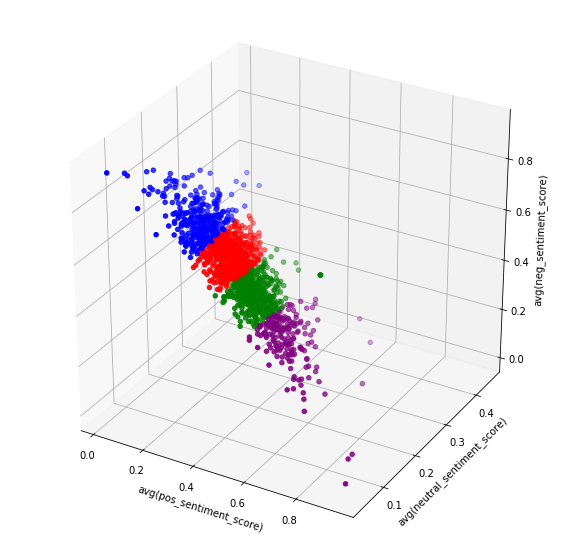

In [0]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Load the dataframe
df = scatter_pdf

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Set the x, y, and z axis labels
ax.set_xlabel('avg(pos_sentiment_score)')
ax.set_zlabel('avg(neg_sentiment_score)')
ax.set_ylabel('avg(neutral_sentiment_score)')

# Define the color map
colors = {0: 'red', 1: 'blue', 2: 'green', 3: 'purple'}
df['color'] = df['prediction'].map(colors)

# Add the data points to the plot
ax.scatter( df['avg(pos_sentiment_score)'], df['avg(neutral_sentiment_score)'], df['avg(neg_sentiment_score)'],
           c=df['color'], marker='o')

# Show the plot
plt.show()


In [0]:
def sparseToDenseArray(sparse_array):
    return sparse_array.toArray().tolist()

udf_sparse_dense_array = udf(sparseToDenseArray, ArrayType(FloatType()))

save = True
try:
    cluster_results = read_df_from_mongo(spark, "4_company_clusters")
    if cluster_results.count():
        save = False
except:
    pass

if save:
    cluster_results =  features_df.select("company", udf_sparse_dense_array(features_df["features"]).alias("features"), "prediction")
    store_df_to_mongo(spark, cluster_results, "4_company_clusters")

In [0]:
plot_df = merged_df.join(features_df, "company")
scatter_pdf = plot_df.toPandas()

In [0]:
scatter_pdf.groupby("prediction").head(10).sort_values("prediction")[["company","prediction"]]

,company,prediction
0,"STANLEY BLACK & DECKER, INC.",0
14,TRUSTMARK CORP,0
12,OMNICOM GROUP INC.,0
11,"Hercules Capital, Inc.",0
9,COMCAST CORP,0
7,KLA CORP,0
10,MGE ENERGY INC,0
5,AMEDISYS INC,0
2,"Quad/Graphics, Inc.",0
1,NORTHERN TRUST CORP,0


#### ML Goals (Group 5) - Gurusankar Gopalakrishnan

Obtain sentiment scores from Form 10k filings of all companies in the Rusell 3000 Index. The Rusell 3000 Index is a broad market index which represents 98% of the public equity market.

Perform unsupervised clustering to see if there are any interesting patterns based on sentiment scores. This will potentially help us identify companies with similar sentiments of their 10K reports.

#### ML Outcome

Used Finbert to predict sentiment scores(Positive negative and nuetral) for 1960 form 10k filings(~1600 unique stocks). While this is a drop over the initally intended 3000 stocks, the market capitalization for these 1600 stocks should be covering atleast 90% of the public US equity market. 

After preprocessing, we are left with 1470 companies that have clean feature sets. For these 1470 companies I have built an unsupervised K-Means clustering algorithm using spark ML.

##### The best silhouette score of 0.48274393503148294 was acheived with K=4.

The respective cluster sizes were [517, 348, 417, 188]. It is interesting to observe from the visualizations that neutral sentiment scores are hardly useful to cluster the companies, and only postive and negative sentiment scores are helpful in clustering. We can perform further analyses here, but this ML exercise was performed as an experiment to use spark ML for simple clustering.